In [1]:
import pandas as pd
import numpy as np
import re 
import string
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline


In [2]:
df_true = pd.read_csv("../dataset/True.csv")
df_fake = pd.read_csv("../dataset/Fake.csv")

In [3]:
df_true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
df_fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# Labeling news
df_true["label"] = 1
df_fake["label"] = 0

In [6]:
# Extracting data for manual testing
df_true_mtesting = df_true.tail(10)
for t in range(df_true.shape[0]-1,df_true.shape[0]-11,-1):
    df_true.drop([t], axis = 0,inplace = True)
    
df_fake_mtesting = df_fake.tail(10)
for f in range(df_fake.shape[0]-1,df_fake.shape[0]-11,-1):
    df_fake.drop([f], axis = 0,inplace = True)

In [7]:
df_true.shape , df_fake.shape

((21407, 5), (23471, 5))

In [62]:
# Creating csv file for manual-testing 
df_mtesting = pd.concat([df_fake_mtesting,df_true_mtesting], axis = 0)
df_mtesting.to_csv("../dataset/manual-testing.csv",index=False)

In [9]:
# Merging both True and Fake news dataset
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.reset_index(drop=True,inplace=True)

In [10]:
df_merge.head(5)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [11]:
df_merge.shape

(44878, 5)

In [12]:
df_merge.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [13]:
# Checking for blank rows (text column)
blank_rows = []
for index, text in df_merge["text"].iteritems():
    if text.isspace():
        blank_rows.append(index)
len(blank_rows)

631

In [14]:
df_merge['text'][11041]

' '

In [15]:
# Remooving blank rows
df_merge.drop(index=blank_rows,axis=0,inplace=True)

In [16]:
df_merge.shape

(44247, 5)

In [17]:
# Adding title and text column into single column total
df_merge['total'] = df_merge["title"] + df_merge['text']

In [18]:
# Assigning to new dataframe 'df' after removing unnecessary features
df = df_merge.drop(["title","text","subject","date"],axis=1)

In [19]:
df.head(5)

,label,total
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...


In [20]:
# Shuffling data
df = shuffle(df)
df.head(10)

,label,total
30905,1,"Republicans gain governorships, but North Caro..."
12193,0,HUH? GERMANS BOMBED PEARL HARBOR? Congressman ...
20911,0,STAND UP AND CHEER! UKIP Party Leader SLAMS Ge...
12598,0,GUESS WHO’S BEHIND Sickening Ad Showing Boy Be...
22537,0,Trump Attacks Hillary: “She is a world class l...
14241,0,OBAMA FAMILY AND 40 CONGRESSIONAL MOOCHERS Arr...
6030,0,Report: Clinton May Pick Elizabeth Warren As ...
26517,1,Trump does not intend to fire investigator Mue...
22011,0,Trump Springs the Neocon Trap Again: North Ko...
38812,1,Sunni Iraq VP supports PM Abadi for second ter...


In [21]:
# Resetting Index
df.reset_index(drop=True,inplace = True)
df.head()

,label,total
0,1,"Republicans gain governorships, but North Caro..."
1,0,HUH? GERMANS BOMBED PEARL HARBOR? Congressman ...
2,0,STAND UP AND CHEER! UKIP Party Leader SLAMS Ge...
3,0,GUESS WHO’S BEHIND Sickening Ad Showing Boy Be...
4,0,Trump Attacks Hillary: “She is a world class l...


## Data Cleaning

In [22]:
# Importing libraries for cleaning puprose

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lemma=WordNetLemmatizer() #intialiting Lemmtizer object
stopwordslist = stopwords.words('english') #stopwords of NLTK
print(len(stopwordslist))

179


In [23]:
# Data cleaning function
def wordclean(text):
    cleantext = ""
    text = text.lower()
    #simplifying text
    text=re.sub(r"i'm","i am",text)
    text=re.sub(r"he's","he is",text)
    text=re.sub(r"she's","she is",text)
    text=re.sub(r"that's","that is",text)
    text=re.sub(r"what's","what is",text)
    text=re.sub(r"where's","where is",text)
    text=re.sub(r"\'ll"," will",text)
    text=re.sub(r"\'ve"," have",text)
    text=re.sub(r"\'re"," are",text)
    text=re.sub(r"\'d"," would",text)
    text=re.sub(r"won't","will not",text)
    text=re.sub(r"can't","cannot",text)
    
    text = re.sub('https?://\S+|www\.\S+','',text) #removes links eg. http://url.com/bla1
    # text = re.sub('\[.*?\]','',text)
    text = re.sub(r'\W',' ',text) #removes non word character
    text = re.sub(r'<.*?>+','',text) 
    text = re.sub('[%s]'% re.escape(string.punctuation),'',text) #removes punctuation marks
    text = re.sub(r'\n','',text) #removes new line character
    text = re.sub('\w*\d\w*','',text) #removes word wich contain number eg. 12is, trum5
    text=re.sub(r"\s+"," ",text)
    
    for word in text.split(): 
        if word not in stopwordslist:   
            cleantext+=lemma.lemmatize(word)+" "  # Removing stopwords as well as lemmetizing words
    return cleantext

In [24]:
# Cleaning text Data
df["total"] = df["total"].apply(wordclean)

## Feature Selection & Train and Test Splitting

In [25]:
# Defining x and y as feature and label respectively
x= df['total']
y = df['label']

In [88]:
# Train-Test splitting
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =0.33)

In [91]:
x_test

28016    jared fogle sue parent victim say fault screwe...
12622    president trump cbs morning relationship barac...
9980     collusion fusion doj official cia wife hired r...
42452    senator seek explanation career u prosecutor a...
35231    new video antifa terror group infiltrated tran...
                               ...                        
35750    kuwait say gcc keep operating despite qatar cr...
39040    boom marco rubio best line day comey hearing v...
29190    breaking senate strike back obama slap victim ...
8955     ndaa obama sign countering disinformation prop...
35936    sociopathic liar hillary hid serious health is...
Name: total, Length: 14602, dtype: object

## TFIDF - Converting Text Data Into Vectors

In [27]:
# Importing TFIDFvectorizer transformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
TV = TfidfVectorizer() # Intializing TFIDFVectorization object 
xv_train = TV.fit_transform(x_train) # Fitting TV model with train text data
xv_test = TV.transform(x_test) # Transforming test text data in TV model

# Model Bulding 

## Defining Some Functions

In [29]:
# For printing confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization'.center(60))

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')

In [30]:
# For printing ROC graph with auc score
def get_ROC(M0del,y_test, xv_test):
    y_pred_proba = LR.predict_proba(xv_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [31]:
# Pinting various matrics of model
def get_matrics(y_test, pred):
    print("Accuracy :".rjust(25), accuracy_score(y_test, pred, normalize=True))
    print("Precision :".rjust(25), precision_score(y_test, pred))
    print("Recall :".rjust(25), recall_score(y_test, pred))
    print("F1 :".rjust(25), f1_score(y_test, pred))

## FND using Logistic Regression

In [32]:
# Importing Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [33]:
LR = LogisticRegression(n_jobs=-1) # Intializing Logistic Regression object
LR.fit(xv_train,y_train) # Fitting model with vectorized text data and binary labels

LogisticRegression(n_jobs=-1)

In [34]:
LRpred = LR.predict(xv_test) # Testing data

------------------------------------------------------------
               FND USING LOGISTIC REGRESSION                
------------------------------------------------------------
               Accuracy : 0.986919600054787
              Precision : 0.9831176139561058
                 Recall : 0.9899419181187137
                     F1 : 0.9865179642831933
------------------------------------------------------------
                   Classification_report                    
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7543
           1       0.98      0.99      0.99      7059

    accuracy                           0.99     14602
   macro avg       0.99      0.99      0.99     14602
weighted avg       0.99      0.99      0.99     14602

------------------------------------------------------------
                            ROC                             
------

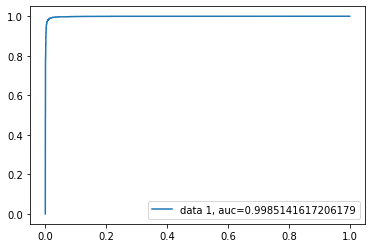

------------------------------------------------------------
          Confusion matrix, without normalization           
------------------------------------------------------------


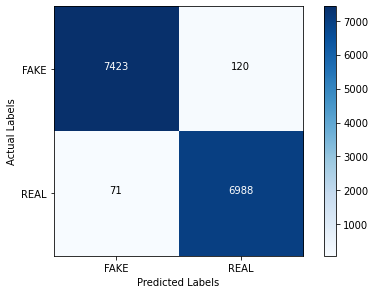

In [35]:
# Generating intutive report on trained Logistic Regression model
print("-"*60)
print("FND USING LOGISTIC REGRESSION".center(60))
print("-"*60)
get_matrics(y_test,LRpred)
print("-"*60)
print("Classification_report".center(60))
print("-"*60)
print(classification_report(y_test,LRpred))
print("-"*60)
print("ROC".center(60))
print("-"*60)
get_ROC(LR,y_test,xv_test)
print("-"*60)
cmLR = confusion_matrix(y_test, LRpred)
plot_confusion_matrix(cmLR,classes=['FAKE', 'REAL'])
print("-"*60)

## FND using Decision Tree Classifier

In [36]:
# Importing Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier 

In [37]:
DTC = DecisionTreeClassifier() # Intializing Decision Tree Classifier object
DTC.fit(xv_train, y_train) # Fitting model with vectorized text data and binary labels

DecisionTreeClassifier()

In [38]:
DTCpred = DTC.predict(xv_test) # Testing data

------------------------------------------------------------
             FND USING DECISION TREE CLASIFIER              
------------------------------------------------------------
               Accuracy : 0.9957540063005068
              Precision : 0.9968754438290016
                 Recall : 0.9943334749964584
                     F1 : 0.9956028368794326
------------------------------------------------------------
                   Classification_report                    
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7543
           1       1.00      0.99      1.00      7059

    accuracy                           1.00     14602
   macro avg       1.00      1.00      1.00     14602
weighted avg       1.00      1.00      1.00     14602

------------------------------------------------------------
                            ROC                             
-----

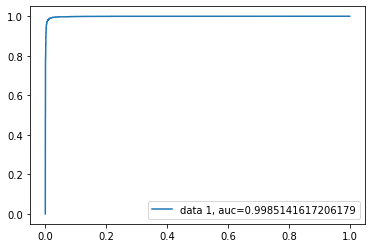

------------------------------------------------------------
          Confusion matrix, without normalization           
------------------------------------------------------------


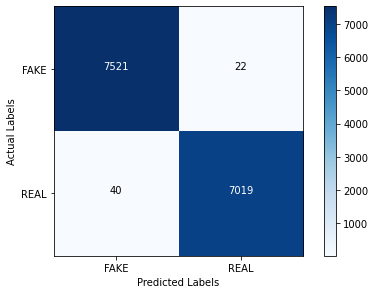

In [39]:
# Generating intutive report on trained Decision Tree Classifier
print("-"*60)
print("FND USING DECISION TREE CLASIFIER".center(60))
print("-"*60)
get_matrics(y_test,DTCpred)
print("-"*60)
print("Classification_report".center(60))
print("-"*60)
print(classification_report(y_test,DTCpred))
print("-"*60)
print("ROC".center(60))
print("-"*60)
get_ROC(DTC,y_test,xv_test)
print("-"*60)
cmDTC = confusion_matrix(y_test, DTCpred)
plot_confusion_matrix(cmDTC,classes=['FAKE', 'REAL'])
print("-"*60)

## FND using Gradient Boosting Classifier

In [40]:
# Importing Gradient Boosting Classifer
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
GBC = GradientBoostingClassifier(random_state=0,learning_rate=0.001) # Intializing Gradient Boosting Classifer object
GBC.fit(xv_train, y_train) # Fitting model with vectorized text data and binary labels

GradientBoostingClassifier(learning_rate=0.001, random_state=0)

In [42]:
GBCpred = GBC.predict(xv_test) # Testing data

------------------------------------------------------------
           FND USING GRADIENT BOOSTING CLASSIFIER           
------------------------------------------------------------
               Accuracy : 0.9945897822216134
              Precision : 0.9909960607765897
                 Recall : 0.9978750531236719
                     F1 : 0.9944236606197501
------------------------------------------------------------
                   Classification_report                    
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7543
           1       0.99      1.00      0.99      7059

    accuracy                           0.99     14602
   macro avg       0.99      0.99      0.99     14602
weighted avg       0.99      0.99      0.99     14602

------------------------------------------------------------
                            ROC                             
-----

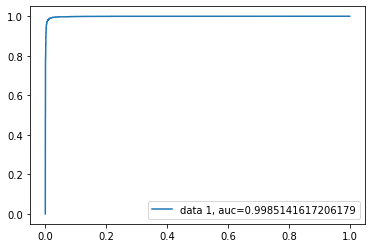

------------------------------------------------------------
          Confusion matrix, without normalization           
------------------------------------------------------------


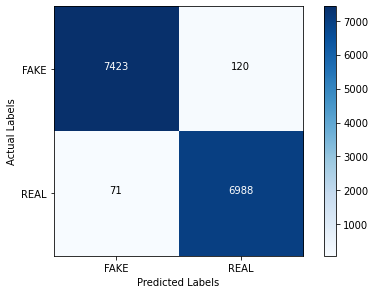

In [43]:
# Generating intutive report on trained Gradient Boosting Classifer model
print("-"*60)
print("FND USING GRADIENT BOOSTING CLASSIFIER".center(60))
print("-"*60)
get_matrics(y_test,GBCpred)
print("-"*60)
print("Classification_report".center(60))
print("-"*60)
print(classification_report(y_test,GBCpred))
print("-"*60)
print("ROC".center(60))
print("-"*60)
get_ROC(GBC,y_test,xv_test)
print("-"*60)
cmGBC = confusion_matrix(y_test, LRpred)
plot_confusion_matrix(cmGBC,classes=['FAKE', 'REAL'])
print("-"*60)

## FND using Random Forest Classifier

In [44]:
# Importing Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [45]:
RFC = RandomForestClassifier(random_state=0,n_jobs=-1) # Intializing Random Forest Classifier object
RFC.fit(xv_train, y_train) # Fitting model with vectorized text data and binary labels

RandomForestClassifier(n_jobs=-1, random_state=0)

In [46]:
RFCpred = RFC.predict(xv_test) # Testing data

------------------------------------------------------------
             FND USING RANDOM FOREST CLASSIFIER             
------------------------------------------------------------
               Accuracy : 0.9914395288316669
              Precision : 0.98982763492512
                 Recall : 0.9924918543703074
                     F1 : 0.9911579543043078
------------------------------------------------------------
                   Classification_report                    
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7543
           1       0.99      0.99      0.99      7059

    accuracy                           0.99     14602
   macro avg       0.99      0.99      0.99     14602
weighted avg       0.99      0.99      0.99     14602

------------------------------------------------------------
                            ROC                             
-------

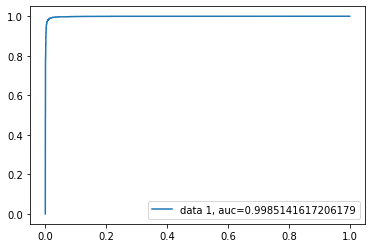

------------------------------------------------------------
          Confusion matrix, without normalization           
------------------------------------------------------------


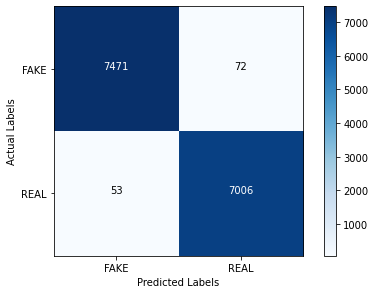

In [47]:
# Generating intutive report on trained Random Forest Classifier
print("-"*60)
print("FND USING RANDOM FOREST CLASSIFIER".center(60))
print("-"*60)
get_matrics(y_test,RFCpred)
print("-"*60)
print("Classification_report".center(60))
print("-"*60)
print(classification_report(y_test,RFCpred))
print("-"*60)
print("ROC".center(60))
print("-"*60)
get_ROC(RFC,y_test,xv_test)
print("-"*60)
cmRFC = confusion_matrix(y_test, RFCpred)
plot_confusion_matrix(cmRFC,classes=['FAKE', 'REAL'])
print("-"*60)

# Manual Testing

In [48]:
# def op_label(t):
#     if t == 0:
#         return "Fake News"
#     elif t == 1:
#         return "True News"
# def manual_testing(news):
#     test_news = {"text":[news]}
#     df_test = pd.DataFrame(test_news)
#     df_test["text"] = df_test["text"].apply(wordclean)
#     x_mtesting = df_test["text"]
#     xv_mtesting = V.transform(x_mtesting)
#     LRtestpred = m.predict(xv_mtesting)
#     DTCtestpred = DTC.predict(xv_mtesting)
#     GBCtestpred = GBC.predict(xv_mtesting)
#     RFCtestpred = RFC.predict(xv_mtesting)
#     return print(f"\n\nLR Prediction : {op_label(LRtestpred[0])}") 
#                  #\nDT Prediction: {op_label(DTCtestpred[0])} \nGBC Prediction: {op_label(GBCtestpred[0])} \nRFC Prediction: {op_label(RFCtestpred[0])}")
# while True:
#     news = input()
#     manual_testing(str(news))
#     if news == "done":
#         break

KeyboardInterrupt: Interrupted by user